In [139]:
#### ADJUST THE INPUTS BELOW AND RUN ALL CELLS TO COMPARE THE LCOE OF FUSION POWER CONVERSION STRATEGIES ##### 

inputs = {
    "power": 500,                    # MW, output power
    "specific_CAPEX_FOAK": 10000,    # USD/kW, assumes a fusion reactor with conventional thermal-to-electric power conversion as the baseline
    "unit_no":  4,                   # Specifies how many reactors have been built to date (for learning rate calculations)
    "learning_rates": [0.20, 0.25],  # %/100, Rate at which reactor cost falls for every doubling of installed capacity
    "powercost": 0.10,               # USD/kWh, regional power cost
    "discount_rate": 0.06,           # %/100
    "project_lifespan": 40,          # Years
    "construction_time": [5, 4],     # Years, construction time for [Thermal-to-Electric, Direct EM Capture] power conversion types
    "Qeng": [10, 5],                 # Energy Gain values for [Thermal-to-Electric, Direct EM Capture] power conversion types
    "capacity_factor": [0.85, 0.75], # Utilization percentage for [Thermal-to-Electric, Direct EM Capture] power conversion types 
    "regulatory_factor": 0           # Percent change to fusion plant CAPEX as a result of DEC-specific regulations

}

In [140]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import pandas as pd
from tabulate import tabulate 


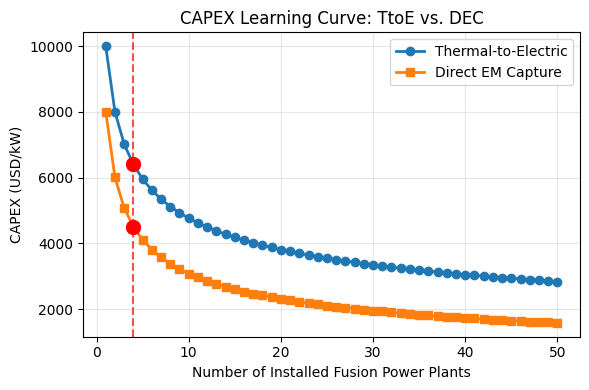

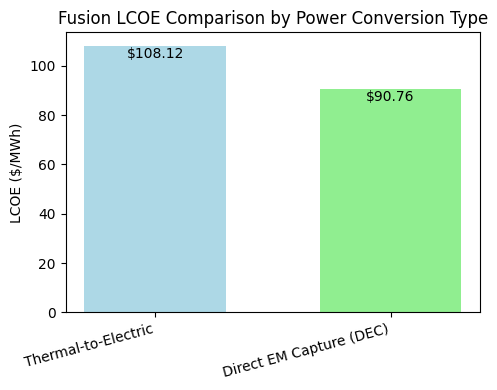

+---------------------------------------------------+-----------------------+---------------------+
| Metric                                            | Thermal-to-Electric   | Direct EM Capture   |
+===================================================+=======================+=====================+
| CAPEX (M$)                                        | 3200                  | 2253                |
+---------------------------------------------------+-----------------------+---------------------+
| OPEX (discounted over lifetime, M$)               | 887                   | 1300                |
+---------------------------------------------------+-----------------------+---------------------+
| Replacement Costs (discounted over lifetime, M$)  | 439                   | {Not Included}      |
+---------------------------------------------------+-----------------------+---------------------+
| Energy Generation (discounted over lifetime, MWh) | 41,859,433.0          | 39,150,881.0        |


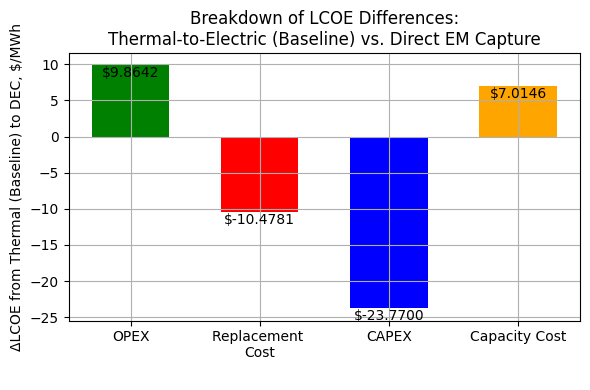

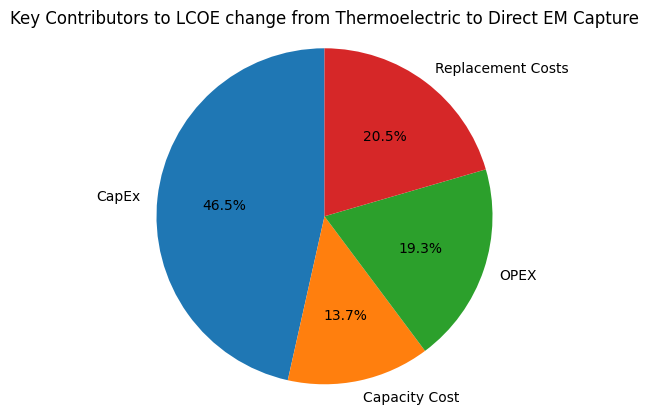

In [141]:

def run(inputs: dict) -> dict:
    # Extract inputs
    P = inputs["power"]                                 # Output Power
    specific_CAPEX = inputs["specific_CAPEX_FOAK"]      # USD/kW, average CAPEX estimate for "conventional" reactor w/ Thermal-to-Electric Power Conversion
    unit_no = inputs["unit_no"]                         # Specifies how many reactors have been built to date (for learning rate calculations)
    LR = inputs["learning_rates"]                       # %/100, CAPEX Learning Rates,  [Thermal-to-Electric, Direct Energy Capture].    
    powercost = inputs["powercost"]                     # Regional Power Cost
    r = inputs["discount_rate"]                         # Discount Rate
    N = inputs["project_lifespan"]                      # Lifespan
    Tc = inputs["construction_time"]                    # Construction time, years.  DEC assumed to be shorter because of smaller footprint and BOM     
    Q = inputs["Qeng"]                                  # Qeng, based on Helion Data, MIT Energy Initiative (2024), Parisi et al. (2025)
    CF = inputs["capacity_factor"]                      # Capacity factor for a Reactor w/ [Thermal-to-Electric, Direct Energy Capture]. DEC is assumed to be less because of fast pulsing requirements
    reg_change = inputs["regulatory_factor"]            # % change to baseline CAPEX as a result of DEC-specific regulations. DEC is assumed to be lower because of lower radioactive waste
    hrs_per_year = 8760   # Hours

    ##### CAPEX Calcs #######

    CAPEX_TtoE_FOAK = specific_CAPEX * P *1e3  # USD
    building_frac = 0.16                       # %/100, Structures + Facilities percentage of TOC for D-T Fusion Baseline, from MIT Energy Initiative 2024
    size_reduction = -0.3                      # %/100, change to DEC facility size from D-T fusion baseline, ROM estimate          
    footprint_delta = (building_frac 
        * specific_CAPEX * size_reduction)     # USD/kW DEC will be ~30% smaller due to higher power conversion efficiency and lack of turbine hall
    turbine_delta = -0.125 * specific_CAPEX    # USD/kW, approx. cost of steam turbine/generator system that gets eliminated with DEC, from MIT Energy Initiative, 2024 
    BoP_delta = -0.02 * specific_CAPEX         # USD/kW, approx. cost of cooling towers, heat exchangers, etc. that get elimintated with DEC, ROM estimate from MIT Energy Initiative, 2024 
    blanket_frac = -0.06                       # %/100, blanket percentage of TOC for D-T Fusion Baseline, from Araiinejad and Shirvan, 2024
    blanket_delta = (blanket_frac
        * specific_CAPEX)                      # USD/kW,  approx. cost of blanket architecture that gets eliminated with DEC, from Schwartz et al., 2024
    waste_frac = -0.05                         # %/100, blanket percentage of TOC for D-T Fusion Baseline, from Araiinejad and Shirvan, 2024
    waste_delta = (waste_frac
        * specific_CAPEX)                      # USD/kW,  approx. cost of blanket architecture that gets eliminated with DEC, from Schwartz et al., 2024
    pwr_electr_delta = 1040                    # USD/kW, approx. cost of additional power electronics and controls required for high-frequency DEC, ROM estimate
    
    total_CAPEX_delta = P * 1e3 * (pwr_electr_delta + turbine_delta + BoP_delta + blanket_delta + footprint_delta + waste_delta) # DEC CAPEX is assumed to be less, given the simpler power conversion architecture
    CAPEX_DEC_FOAK = (CAPEX_TtoE_FOAK * (1 + reg_change/100)) + total_CAPEX_delta  # USD
    
    # Compute CAPEX using Wright's law: C(n) = C_FOAK * n^b, b = log2(1 - LR)
    CAPEX_TtoE = (1/unit_no)**(-1*np.log2(1-LR[0])) * CAPEX_TtoE_FOAK  # USD
    CAPEX_DEC = (1/unit_no)**(-1*np.log2(1-LR[1])) * CAPEX_DEC_FOAK  # USD
   
    ##### Energy Generation Calcs #########
    
    T_Deg = [0.0, 0.0]  # Temporal degradation of generation output per year, [Thermal-to-Electric, Direct Energy Capture].
    
    disc_E_TtoE = P * hrs_per_year * CF[0] * np.sum((1 - T_Deg[0])**(n-1) / ((1 + r)**(n + Tc[0])) for n in range(1, N+1)) # Discounted energy generation over lifespan, inc. degradataion, Thermal To Electric
    disc_E_DEC = P * hrs_per_year * CF[1] * np.sum((1 - T_Deg[1])**(n-1) / ((1 + r)**(n + Tc[1])) for n in range(1, N+1))  # Discounted energy generation over lifespan, inc. degradataion, Direct EM Capture

    ###### OPEX Calcs #######
    
    Pin = [P/(Q[0]), P/(Q[1])]   # MW, input power, [Thermal-to-Electric, Direct Energy Capture].
    specific_OPEX = 20           # USD/MWh, from MIT Energy Initiative, 2024 
    
    OPEX_TtoE =  specific_OPEX * P * CF[0] * hrs_per_year  # OPEX does not include maintenance, calculated below
    OPEX_Delta= (Pin[1] * 1e3 * hrs_per_year * CF[1] * powercost) - (Pin[0] * 1e3 * hrs_per_year * CF[0] * powercost) # Fuel cost delta is ignored since He3 would theoretically be bred within reactor
    OPEX_DEC = OPEX_TtoE + OPEX_Delta 

    disc_OPEX_TtoE = sum(OPEX_TtoE/ (1 + r)**(n+Tc[0]) for n in range(N)) # USD, discounted OPEX over lifespan
    disc_OPEX_DEC = sum(OPEX_DEC/ (1 + r)**(n+Tc[1]) for n in range(N))   # USD, discounted OPEX over lifespan

    ###### Maintenance & Replacement Calcs ###### << Focusing on the delta between Thermal and DEC maintenance costs
    
    replacement_interval = 3       # Years between major maintenance, ROM estimate from Schwartz et al. 2024
    replacement_cost = 250e3 * P   # USD, from Schwartz et al., 2024
    #replacement_cost = 150e3 * P  # USD, from MIT Energy Initiative, 2024 (assumes a 2-year interval)
    
    nrepl = [int(i * replacement_interval) for i in range(1, int(N / replacement_interval) + 1) if int(i * replacement_interval) <= N]    # Calculate replacement intervals
    nrepl = [year for year in nrepl if year < N]     # Ensure replacements don't exceed lifespan
    disc_replacement_costs = sum(replacement_cost/ (1 + r)**(n + Tc[0]) for n in nrepl)    # Replacement costs only count blanket costs and thus only apply to Thermal-to-Electric configs.
    ##### LCOE Calcs #######

    LCOE_TtoE = (CAPEX_TtoE + disc_replacement_costs + disc_OPEX_TtoE) / (disc_E_TtoE * 1000)  #$/kWh
    LCOE_DEC = (CAPEX_DEC + disc_OPEX_DEC) / (disc_E_DEC * 1000)   #$/kWh

    ################# PLOTS ####################
    ######### CAPEX Learning Rate Chart ########
    
    i = np.arange(1, 51, 1) # FPP unit number, parameterized
    
    capex_ttoe = specific_CAPEX * (i ** np.log2(1 - LR[0]))  
    capex_dec = CAPEX_DEC_FOAK/(P*1e3) * (i ** np.log2(1 - LR[1]))   
        
    # Find nearest index to current
    current_idx = np.argmin(np.abs(i - unit_no))
    
    # Line plot with highlight
    plt.figure(figsize=(6, 4))
    plt.plot(i, capex_ttoe, label='Thermal-to-Electric', marker='o', linewidth=2)
    plt.plot(i, capex_dec, label='Direct EM Capture', marker='s', linewidth=2)
    
    # Simple highlight: Vertical line + scatter points + text
    plt.axvline(x=unit_no, color='red', linestyle='--', alpha=0.7)
    plt.scatter(i[current_idx], capex_ttoe[current_idx], color='red', s=100, zorder=5)
    plt.scatter(i[current_idx], capex_dec[current_idx], color='red', s=100, zorder=5)
    
    plt.xlabel('Number of Installed Fusion Power Plants')
    plt.ylabel('CAPEX (USD/kW)')
    plt.title('CAPEX Learning Curve: TtoE vs. DEC')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    ########### LCOE Bar Chart ##############
    
    categories = ['Thermal-to-Electric', 'Direct EM Capture (DEC)']
    lcoe_values = [LCOE_TtoE * 1000, LCOE_DEC * 1000]  # Scale to $/MWh for chart labels
    
    x_pos = np.arange(len(categories))
    width = 0.6
    
    fig, ax = plt.subplots(figsize=(5, 4))
    bars = ax.bar(x_pos, lcoe_values, width, align='center', color=['lightblue', 'lightgreen'])
    
    ax.set_ylabel('LCOE ($/MWh)')
    plt.title('Fusion LCOE Comparison by Power Conversion Type')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, rotation=15, ha='right')
    
    for bar, val in zip(bars, lcoe_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height - 0.5,  
                f'${val:.2f}', ha='center', va='top') 
    
    plt.tight_layout()
    plt.show()

    
    data = {
    'Metric': [
        'CAPEX (M$)',
        'OPEX (discounted over lifetime, M$)',
        'Replacement Costs (discounted over lifetime, M$)',
        'Energy Generation (discounted over lifetime, MWh)',
        'LCOE ($/kWh)'
    ],
    'Thermal-to-Electric': [
        f"{CAPEX_TtoE/1e6:0.0f}",
        f"{(disc_OPEX_TtoE)/1e6:0.0f}",
        f"{disc_replacement_costs/1e6:0.0f}",
        f"{np.round(disc_E_TtoE):,}",
        f"{LCOE_TtoE:0.3f}"
    ],
    'Direct EM Capture': [
        f"{CAPEX_DEC/1e6:0.0f}",
        f"{disc_OPEX_DEC/1e6:0.0f}", 
        "{Not Included}", 
        f"{np.round(disc_E_DEC):,}",
        f"{LCOE_DEC:0.3f}"
    ]
    }
    
    df = pd.DataFrame(data)
    
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

    
    ######### Cost Driver Bar Chart #########
    opexcontr = (disc_OPEX_DEC-disc_OPEX_TtoE) / (disc_E_TtoE) # change to LCOE in $/MWh from OPEX delta (lifetime discounted)
    replcontr = (-1*disc_replacement_costs) / (disc_E_TtoE) # change to LCOE in $/MWh from maintenance cost delta (lifetime discounted)
    capexcontr = (CAPEX_TtoE*(reg_change/100) + total_CAPEX_delta )/(disc_E_TtoE) # change to LCOE in $/MWh from CAPEX delta 
    gencontr = (LCOE_DEC - LCOE_TtoE)*1000 - (opexcontr + replcontr + capexcontr) #change to LCOE in $/MWh from generation throughput delta
    categories = ['OPEX', 'Replacement \nCost', 'CAPEX', 'Capacity Cost']
    values = [opexcontr, replcontr, capexcontr, gencontr]  # $/kWh; multiply by 1000 for $/MWh if needed
    
    x_pos = np.arange(len(categories))
    width = 0.6
    
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(x_pos, values, width, align='center', color=['green', 'red', 'blue', 'orange'])  
    
    ax.set_xlabel(' ')
    ax.set_ylabel('ΔLCOE from Thermal (Baseline) to DEC, $/MWh')
    ax.set_title('Breakdown of LCOE Differences:\nThermal-to-Electric (Baseline) vs. Direct EM Capture')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, rotation=0, ha='center')
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height - max(values)*0.01,  # Slight offset below
                f'${val:.4f}', ha='center', va='top', fontsize=10)
    
    plt.tight_layout()
    plt.grid()
    plt.show()

    
    ######### Pie chart ###########
    sumchange =  abs(opexcontr) + abs(replcontr) + abs(capexcontr) + abs(gencontr)

    percentopex = abs(opexcontr)/ sumchange * 100
    percentrepl = abs(replcontr)/sumchange * 100
    percentcapex = abs(capexcontr)/ sumchange * 100
    percentgen = abs(gencontr)/ sumchange * 100
    
    sizes = [percentcapex, percentgen, percentopex, percentrepl]
    labels = ['CapEx', 'Capacity Cost', 'OPEX', 'Replacement Costs']
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    
    # Equal aspect ratio ensures pie is circular
    ax.axis('equal')
    
    # Add a title
    plt.title('Key Contributors to LCOE change from Thermoelectric to Direct EM Capture')
    
    # Display the chart
    plt.show()


    return {
        "LCOE_thermal": LCOE_TtoE,
        "LCOE_DEC": LCOE_DEC,
        "CAPEX_thermal": CAPEX_TtoE/1e6, #Million USD
        "CAPEX_DEC": CAPEX_DEC/1e6, #Million USD
        "OPEX_thermal": (disc_OPEX_TtoE+ disc_replacement_costs)/1e6, #Million USD
        "OPEX_DEC": disc_OPEX_DEC/1e6, # #Million USD
        "discountedE_TtoE": disc_E_TtoE, #MWh
        "discountedE_DEC": disc_E_DEC #MWh

    }
    
results = run(inputs)


In [142]:
# SOURCES

# The role of fusion energy in a decarbonized electricity system (Report). MIT Energy Initiative, 2024. https://energy.mit.edu/wp-content/uploads/2024/09/MITEI_FusionReport_091124_final_COMPLETE-REPORT_fordistribution.pdf

# Schwartz, J.A., Ricks, W., Kolemen, E. & Jenkins, J.D., 2024. Valuing maintenance strategies for fusion plants as part of a future electricity grid. Available at: https://arxiv.org/pdf/2405.01514

# Araiinejad, L.S. & Shirvan, K., 2024. Techno-economic analysis of deuterium-tritium magnetic confinement fusion power plants (Masters thesis). Available at: https://dspace.mit.edu/handle/1721.1/157003

# Parisi, J.F., Diallo, A. & Meschini, S., 2025. Revisiting Fusion in D-3He Plasmas With Spin-Polarized Fuel. arXiv preprint arXiv:2504.09869. Available at: https://arxiv.org/pdf/2504.09869